Code for **"AlexNet inversion"** figure from the main paper and **"VGG inversion"** from supmat.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/deep-image-prior')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from models import *

import torch
import torch.optim

from utils.feature_inversion_utils import *
from utils.perceptual_loss.perceptual_loss import get_pretrained_net
from utils.common_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
fname = '/content/drive/MyDrive/deep-image-prior/data/feature_inversion/building.jpg'

pretrained_net = 'alexnet_caffe' # 'vgg19_caffe'
layers_to_use = 'fc6' # comma-separated string of layer names e.g. 'fc6,fc7'

# Setup pretrained net

In [4]:
cnn = get_pretrained_net(pretrained_net).type(dtype)

opt_content = {'layers': layers_to_use, 'what':'features'}

# Remove the layers we don't need
keys = [x for x in cnn._modules.keys()]
max_idx = max(keys.index(x) for x in opt_content['layers'].split(','))
for k in keys[max_idx+1:]:
    cnn._modules.pop(k)

print(cnn)

/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1639: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1639: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1639: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute o

Sequential(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU()
  (norm1): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU()
  (norm2): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (torch_view): View()
  (fc6): Linear(in_features=9216, out_features=4096,

# Load image

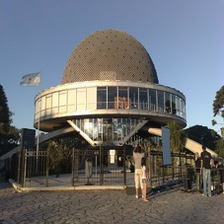

In [5]:
# Target imsize
imsize = 227 if pretrained_net == 'alexnet' else 224

# Something divisible by a power of two
imsize_net = 256

# VGG and Alexnet need input to be correctly normalized
preprocess, deprocess = get_preprocessor(imsize), get_deprocessor()


img_content_pil, img_content_np  = get_image(fname, imsize)
img_content_prerocessed = preprocess(img_content_pil)[None,:].type(dtype)

img_content_pil

# Setup matcher and net

In [6]:
matcher_content = get_matcher(cnn, opt_content)

matcher_content.mode = 'store'
cnn(img_content_prerocessed);

In [7]:
INPUT = 'noise'
pad = 'zero' # 'refection'
OPT_OVER = 'net' #'net,input'
OPTIMIZER = 'adam' # 'LBFGS'
LR = 0.001

num_iter = 3100

input_depth = 32
net_input = get_noise(input_depth, INPUT, imsize_net).type(dtype).detach()

In [8]:
net = skip(input_depth, 3, num_channels_down = [16, 32, 64, 128, 128, 128],
                           num_channels_up =   [16, 32, 64, 128, 128, 128],
                           num_channels_skip = [4, 4, 4, 4, 4, 4],
                           filter_size_down = [7, 7, 5, 5, 3, 3], filter_size_up = [7, 7, 5, 5, 3, 3],
                           upsample_mode='nearest', downsample_mode='avg',
                           need_sigmoid=True, pad=pad, act_fun='LeakyReLU').type(dtype)

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 2606763


# Optimize

In [9]:
def closure():

    global i

    out = net(net_input)[:, :, :imsize, :imsize]

    cnn(vgg_preprocess_var(out))
    total_loss =  sum(matcher_content.losses.values())
    total_loss.backward()

    print ('Iteration %05d    Loss %.3f' % (i, total_loss.item()), '\r', end='')
    if PLOT and i % 200 == 0:
        out_np = np.clip(torch_to_np(out), 0, 1)
        plot_image_grid([out_np], 3, 3);

    i += 1

    return total_loss

In [10]:
i=0
matcher_content.mode = 'match'
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

# Result

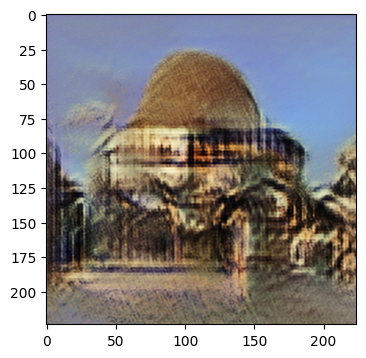

In [11]:
out = net(net_input)[:, :, :imsize, :imsize]
plot_image_grid([torch_to_np(out)], 3, 3);

The code above was used to produce the images from the paper.

# Appedndix: more noise

We also found adding heavy noise sometimes improves the results (see below). Interestingly, network manages to adapt to a very heavy noise.

In [12]:
input_depth = 2
net_input = get_noise(input_depth, INPUT, imsize_net).type(dtype).detach()

net = skip(input_depth, 3, num_channels_down = [16, 32, 64, 128, 128, 128],
                           num_channels_up =   [16, 32, 64, 128, 128, 128],
                           num_channels_skip = [4, 4, 4, 4, 4, 4],
                           filter_size_up = [7, 7, 5, 5, 3, 3], filter_size_down = [7, 7, 5, 5, 3, 3],
                           upsample_mode='nearest', downsample_mode='avg',
                           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

In [13]:
def closure():

    global i
    if i < 10000:
        # Weight noise
        for n in [x for x in net.parameters() if len(x) == 4]:
            n = n + n.detach().clone().normal_()*n.std()/50

        # Input noise
        net_input = net_input_saved + (noise.normal_() * 10)

    elif i < 15000:
        # Weight noise
        for n in [x for x in net.parameters() if len(x) == 4]:
            n = n + n.detach().clone().normal_()*n.std()/100

        # Input noise
        net_input = net_input_saved + (noise.normal_() * 2)

    elif i < 20000:
        # Input noise
        net_input = net_input_saved + (noise.normal_() / 2)


    out = net(net_input)[:, :, :imsize, :imsize]

    cnn(vgg_preprocess_var(out))
    total_loss =  sum(matcher_content.losses.values())
    total_loss.backward()

    print ('Iteration %05d    Loss %.3f' % (i, total_loss.item()), '\r', end='')
    if PLOT and i % 1000==0:
        out_np = np.clip(torch_to_np(out), 0, 1)
        plot_image_grid([out_np], 3, 3);

    i += 1

    return total_loss

In [14]:
num_iter = 20000
LR = 0.01

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
i=0

matcher_content.mode = 'match'
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.